# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/datasets/autos.csv')

In [3]:
data.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [4]:
data.shape

(354369, 16)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [7]:
data['DateCrawled'].max()

'2016-04-07 14:36:58'

Сразу удалим столбцы, которые не будут нужны в обучении модели: `DateCrawled`, `NumberOfPictures`, `PostalCode`, `LastSeen`, `DateCreated`, `RegistrationMonth`

In [8]:
data = data.drop(columns=['DateCrawled', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'DateCreated', 'RegistrationMonth'], axis=1)


In [9]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


Также, для удобства переведем все столбцы в нижний регистр

In [10]:
data.columns = data.columns.str.lower()

In [11]:
data.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [12]:
data = data.rename(columns={'vehicletype':'vehicle_type',
                            'registrationyear':'registration_year',
                            'fueltype': 'fuel_type',
                            'notrepaired':'not_repaired'
})

In [13]:
data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [14]:
data.isna().sum()

price                    0
vehicle_type         37490
registration_year        0
gearbox              19833
power                    0
model                19705
kilometer                0
fuel_type            32895
brand                    0
not_repaired         71154
dtype: int64

Проведем работу с пропусками, а также проверим данные на выборсы и аномалии

### `vehicle_type`

In [15]:
data['vehicle_type'].value_counts()

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: vehicle_type, dtype: int64

In [16]:
data['vehicle_type'].isna().sum()

37490

Так как мы не можем узнать какого типа кузов у машин (только опытном путем, проверяя каждую машину), то заполним все пропуски на "other"

In [17]:
data['vehicle_type'] = data['vehicle_type'].fillna('other')

In [18]:
data['vehicle_type'].isna().sum()

0

In [19]:
data['vehicle_type'].value_counts()

sedan          91457
small          79831
wagon          65166
other          40778
bus            28775
convertible    20203
coupe          16163
suv            11996
Name: vehicle_type, dtype: int64

### `gearbox`

In [20]:
data['gearbox'].value_counts()

manual    268251
auto       66285
Name: gearbox, dtype: int64

In [21]:
data['gearbox'].isna().sum()

19833

In [22]:
data['gearbox'].isna().value_counts(normalize=True)

False    0.944033
True     0.055967
Name: gearbox, dtype: float64

Так как мы не можем заранее знать автоматическая коробка передач или механическая, а это тот параметр, который в корне влияет на цене автомабиля, удалим строки с пропусками в этом столбце

In [23]:
data = data.loc[data['gearbox'].isna() == False]

### `model`

In [24]:
data['model'].value_counts()

golf                  27757
other                 23025
3er                   19086
polo                  12334
corsa                 11791
                      ...  
i3                        7
rangerover                4
serie_3                   3
range_rover_evoque        2
serie_1                   1
Name: model, Length: 250, dtype: int64

In [25]:
data['model'].isna().sum()

15574

Заполним все пропуски на 'other'

In [26]:
data['model'] = data['model'].fillna('other')

In [27]:
data['model'].isna().sum()

0

### `fuel_type`

In [28]:
data['fuel_type'].value_counts()

petrol      209255
gasoline     95126
lpg           5174
cng            551
hybrid         227
other          150
electric        78
Name: fuel_type, dtype: int64

Так как 'petrol' и 'gasoline' одно и то же, объединим их в единое понятие "petrol"

In [29]:
data['fuel_type'] = data['fuel_type'].replace('gasoline', 'petrol')

In [30]:
data['fuel_type'].value_counts()

petrol      304381
lpg           5174
cng            551
hybrid         227
other          150
electric        78
Name: fuel_type, dtype: int64

In [31]:
data['fuel_type'].isna().sum()

23975

Заполним все данные на 'other'

In [32]:
data['fuel_type'] = data['fuel_type'].fillna('other')

In [33]:
data['fuel_type'].isna().sum()

0

### `not_repaired`

In [34]:
data['not_repaired'].value_counts()

no     241629
yes     34541
Name: not_repaired, dtype: int64

In [35]:
data['not_repaired'].isna().sum()

58366

Скорее всего, незаполненные данные означают, что машина не была в ремонте, так что заполним все пропуски значением: "no"

In [36]:
data['not_repaired'] = data['not_repaired'].fillna('no')

In [37]:
data['not_repaired'].isna().sum()

0

### `registration_year`

In [38]:
data['registration_year'].value_counts()

1999    21945
2000    21332
2005    20265
2001    19506
2006    19267
        ...  
4000        1
3500        1
1200        1
3000        1
2800        1
Name: registration_year, Length: 116, dtype: int64

In [39]:
data['registration_year'].describe()

count    334536.000000
mean       2003.379122
std          32.059005
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9000.000000
Name: registration_year, dtype: float64

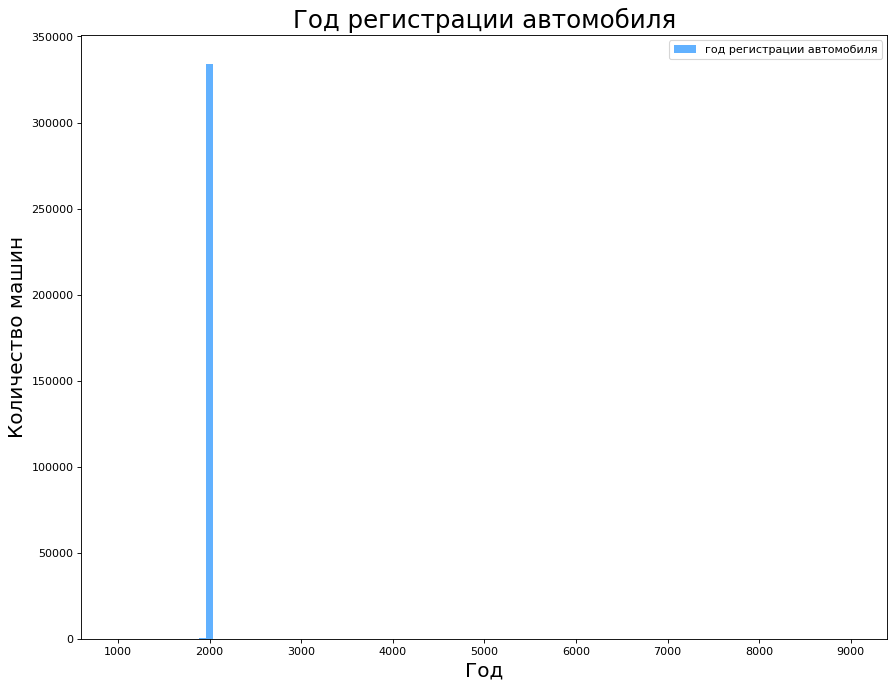

In [40]:
plt.figure(figsize=(13,10), dpi= 80)
sns.distplot(data['registration_year'], color="dodgerblue",label="год регистрации автомобиля", bins=100, 
             hist_kws={'alpha':.7}, kde=False)
plt.title('Год регистрации автомобиля', fontsize=22)
plt.xlabel('Год', fontsize=18)
plt.ylabel('Количество машин', fontsize=18)
plt.legend()
plt.show()

Отсечем все выборсы. Так как дата последней выгрузки стоит за 2016, будем отсчитывать начало производства машин от 1852г и до 2016г

In [41]:
data = data.query('1852 <= registration_year <= 2016')

In [42]:
data['registration_year'].describe()

count    321864.000000
mean       2002.606523
std           6.745615
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registration_year, dtype: float64

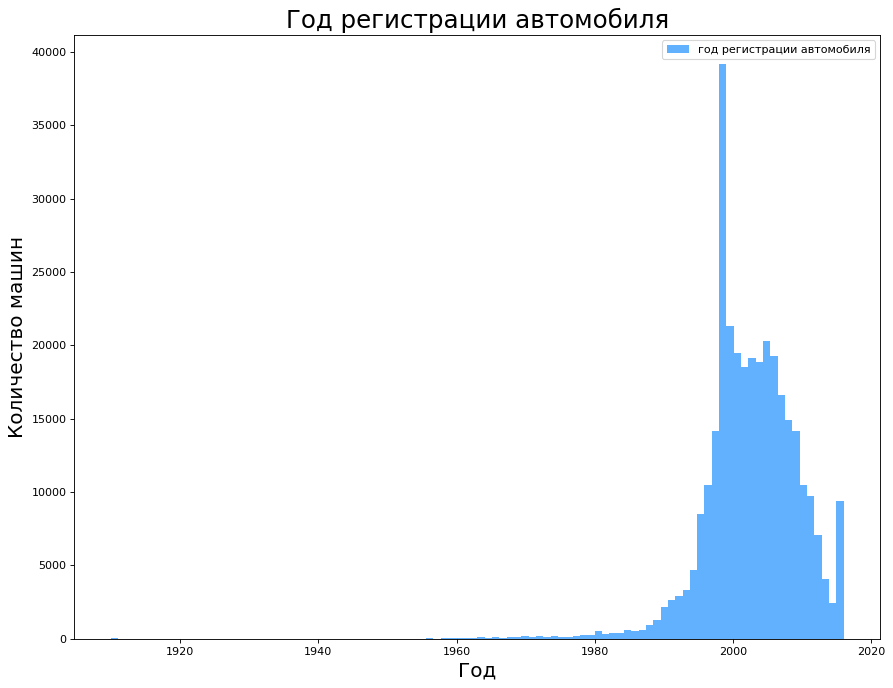

In [43]:
plt.figure(figsize=(13,10), dpi= 80)
sns.distplot(data['registration_year'], color="dodgerblue",label="год регистрации автомобиля", bins=100, 
             hist_kws={'alpha':.7}, kde=False)
plt.title('Год регистрации автомобиля', fontsize=22)
plt.xlabel('Год', fontsize=18)
plt.ylabel('Количество машин', fontsize=18)
plt.legend()
plt.show()

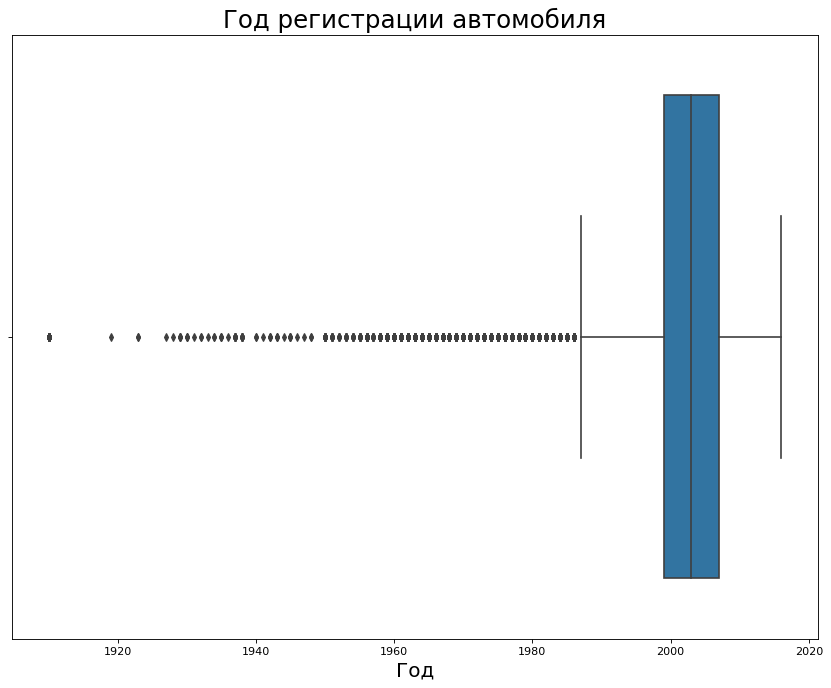

In [44]:
plt.figure(figsize=(13,10), dpi= 80)
sns.boxplot(data['registration_year'])
plt.title('Год регистрации автомобиля', fontsize=22)
plt.xlabel('Год', fontsize=18)
plt.show()

Мы можем наблюдать, что существенное количество зарегистрированный машин начало появляться только после 1980 гг.

Отсечем предыдущие года для точности данных

In [45]:
data = data.query('registration_year > 1980')

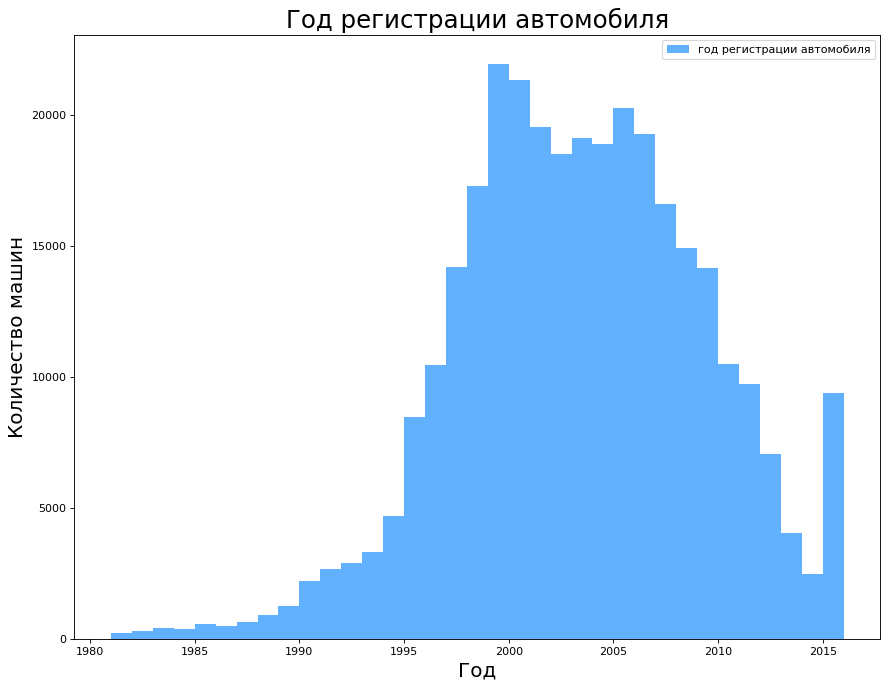

In [46]:
plt.figure(figsize=(13,10), dpi= 80)
sns.distplot(data['registration_year'], color="dodgerblue",label="год регистрации автомобиля", bins=35, 
             hist_kws={'alpha':.7}, kde=False)
plt.title('Год регистрации автомобиля', fontsize=22)
plt.xlabel('Год', fontsize=18)
plt.ylabel('Количество машин', fontsize=18)
plt.legend()
plt.show()

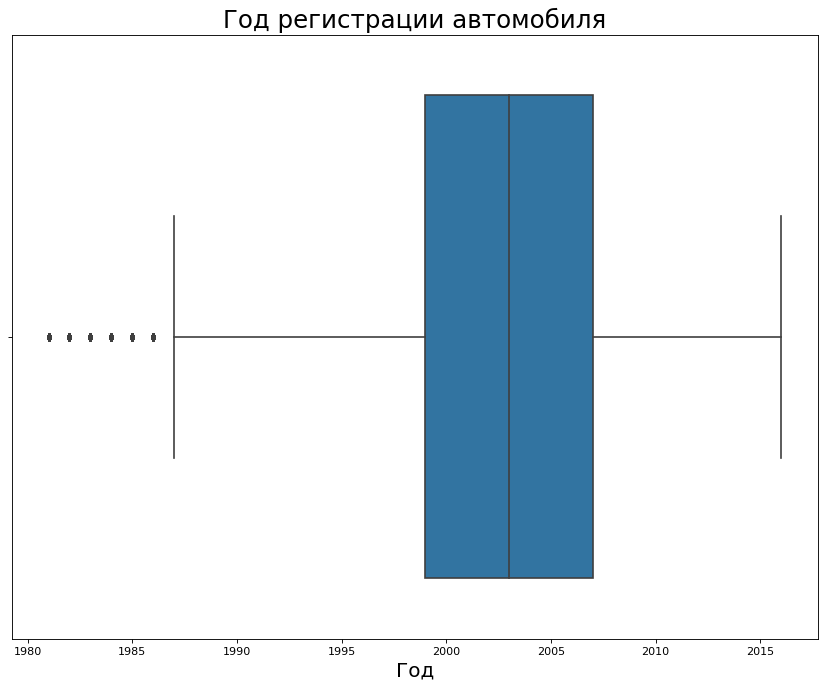

In [47]:
plt.figure(figsize=(13,10), dpi= 80)
sns.boxplot(data['registration_year'])
plt.title('Год регистрации автомобиля', fontsize=22)
plt.xlabel('Год', fontsize=18)
plt.show()

### `power`

In [48]:
data['power'].value_counts()

0        23761
75       22151
60       14643
150      13897
101      12492
         ...  
6045         1
671          1
15001        1
10311        1
1653         1
Name: power, Length: 684, dtype: int64

In [49]:
data['power'].describe()

count    318855.000000
mean        115.450267
std         185.778750
min           0.000000
25%          75.000000
50%         106.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

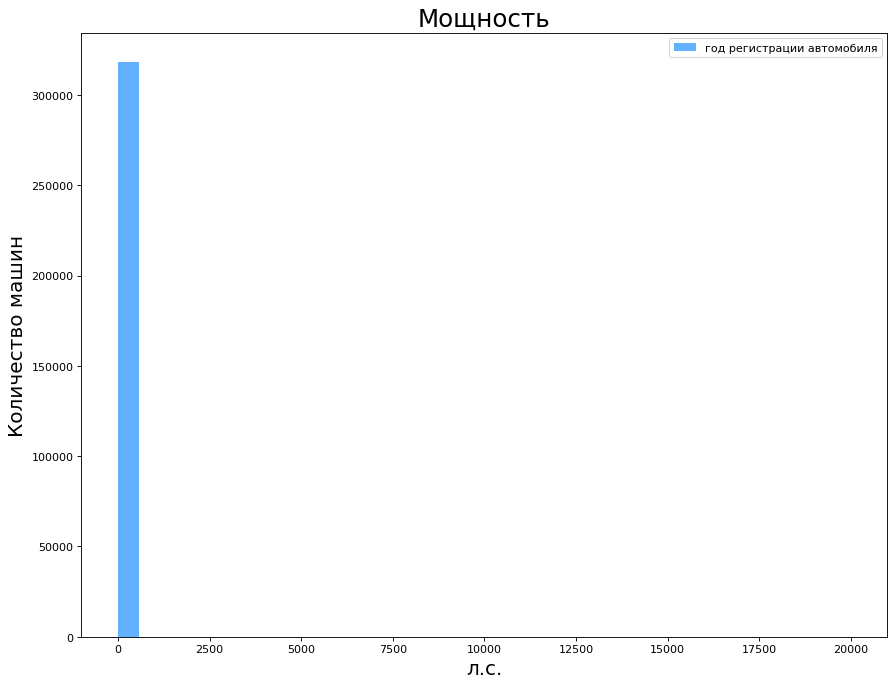

In [50]:
plt.figure(figsize=(13,10), dpi= 80)
sns.distplot(data['power'], color="dodgerblue",label="год регистрации автомобиля", bins=35, 
             hist_kws={'alpha':.7}, kde=False)
plt.title('Мощность', fontsize=22)
plt.xlabel('л.с.', fontsize=18)
plt.ylabel('Количество машин', fontsize=18)
plt.legend()
plt.show()

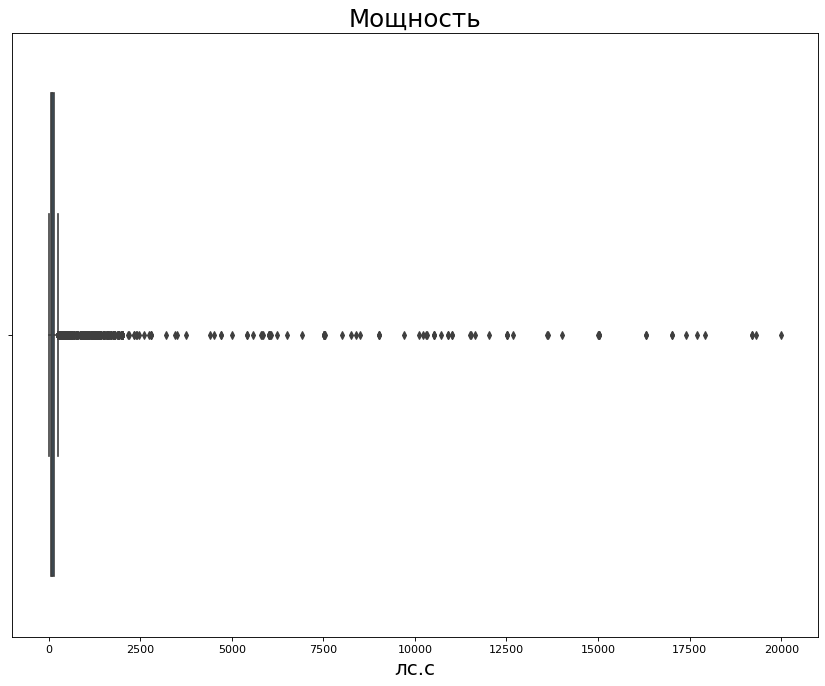

In [51]:
plt.figure(figsize=(13,10), dpi= 80)
sns.boxplot(data['power'])
plt.title('Мощность', fontsize=22)
plt.xlabel('лс.с', fontsize=18)
plt.show()

Не считая "Devel Sixteen" с 5000 л.с. и "Dagger GT" с 2500 л.с., остальные машины имеют максиум 1600 л.с. поэтому все остальное уберем из данных.

In [52]:
data = data.query('power < 1600')

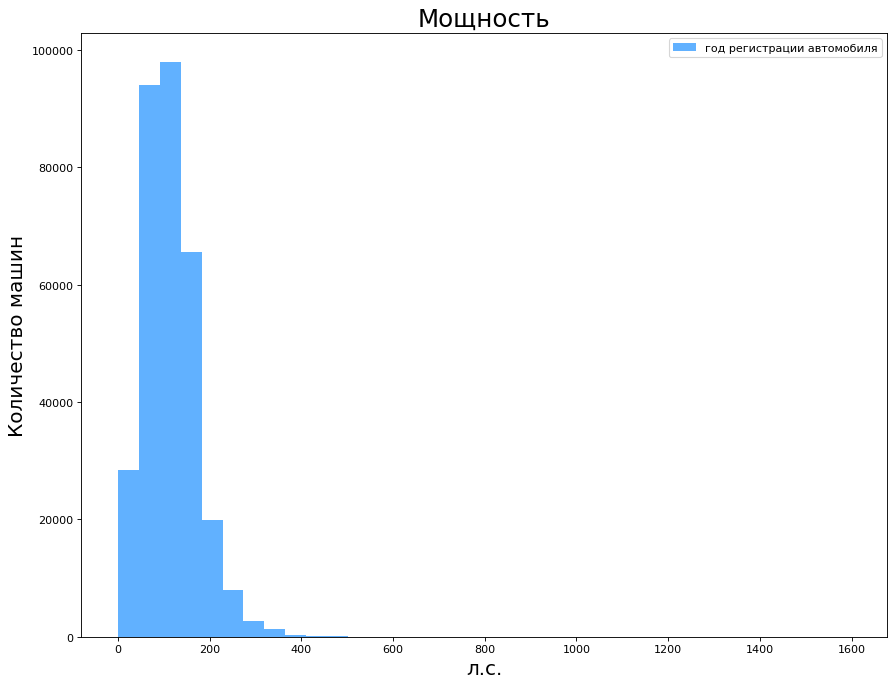

In [53]:
plt.figure(figsize=(13,10), dpi= 80)
sns.distplot(data['power'], color="dodgerblue",label="год регистрации автомобиля", bins=35, 
             hist_kws={'alpha':.7}, kde=False)
plt.title('Мощность', fontsize=22)
plt.xlabel('л.с.', fontsize=18)
plt.ylabel('Количество машин', fontsize=18)
plt.legend()
plt.show()

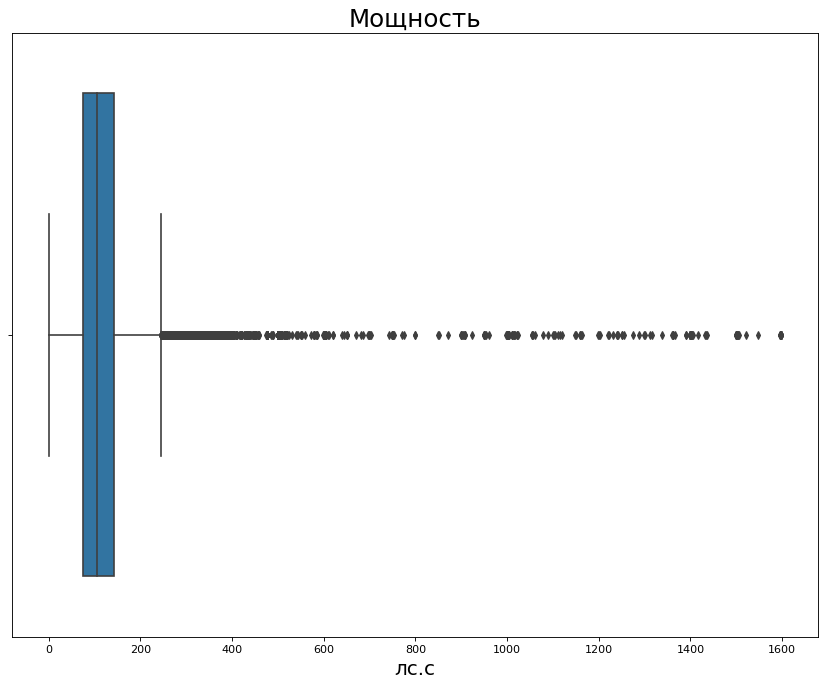

In [54]:
plt.figure(figsize=(13,10), dpi= 80)
sns.boxplot(data['power'])
plt.title('Мощность', fontsize=22)
plt.xlabel('лс.с', fontsize=18)
plt.show()

Можно заметить, что не так много людей, обладающие спорткарами, хотят их продать. Поэтому для точности данных отсечем еще часть "выборосов" и ограничемся 1000 л.с.

Также, мы можем заметить, что очень много машин с мощностью 0-40 л.с. Так как мы никак не можем заменить эти данные, придется отсечь эти данные

In [55]:
data = data.query('40 <= power <= 1000')

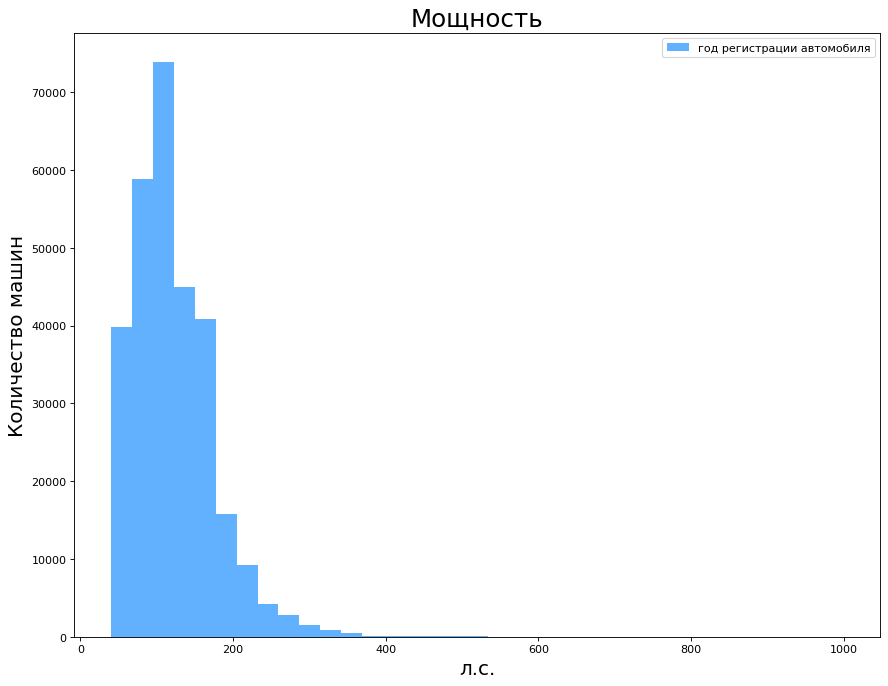

In [56]:
plt.figure(figsize=(13,10), dpi= 80)
sns.distplot(data['power'], color="dodgerblue",label="год регистрации автомобиля", bins=35, 
             hist_kws={'alpha':.7}, kde=False)
plt.title('Мощность', fontsize=22)
plt.xlabel('л.с.', fontsize=18)
plt.ylabel('Количество машин', fontsize=18)
plt.legend()
plt.show()

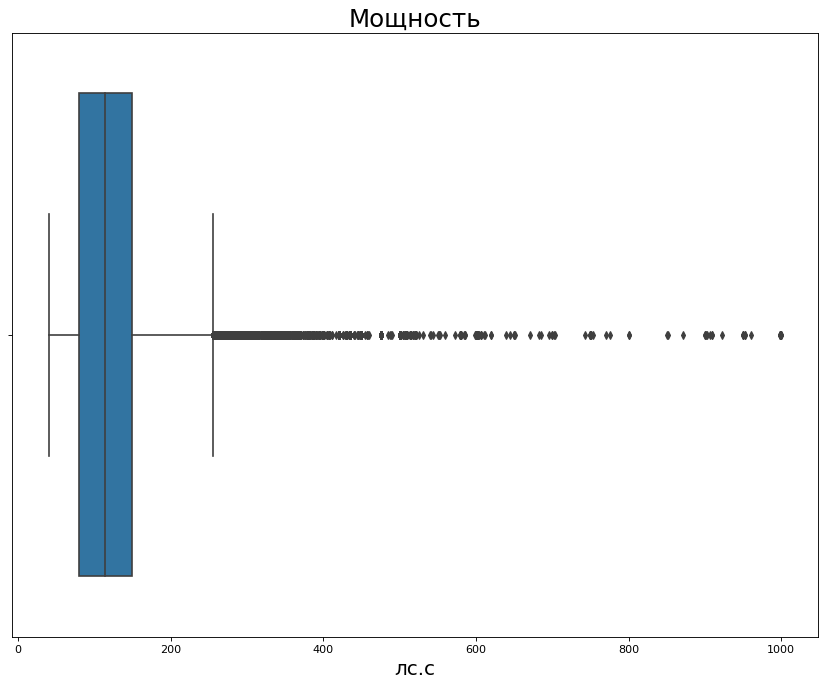

In [57]:
plt.figure(figsize=(13,10), dpi= 80)
sns.boxplot(data['power'])
plt.title('Мощность', fontsize=22)
plt.xlabel('лс.с', fontsize=18)
plt.show()

### `kilometer`

In [58]:
data['kilometer'].value_counts()

150000    196824
125000     31384
100000     12437
90000      10066
80000       8790
70000       7569
60000       6595
50000       5454
40000       4345
30000       3752
20000       3113
5000        2738
10000        862
Name: kilometer, dtype: int64

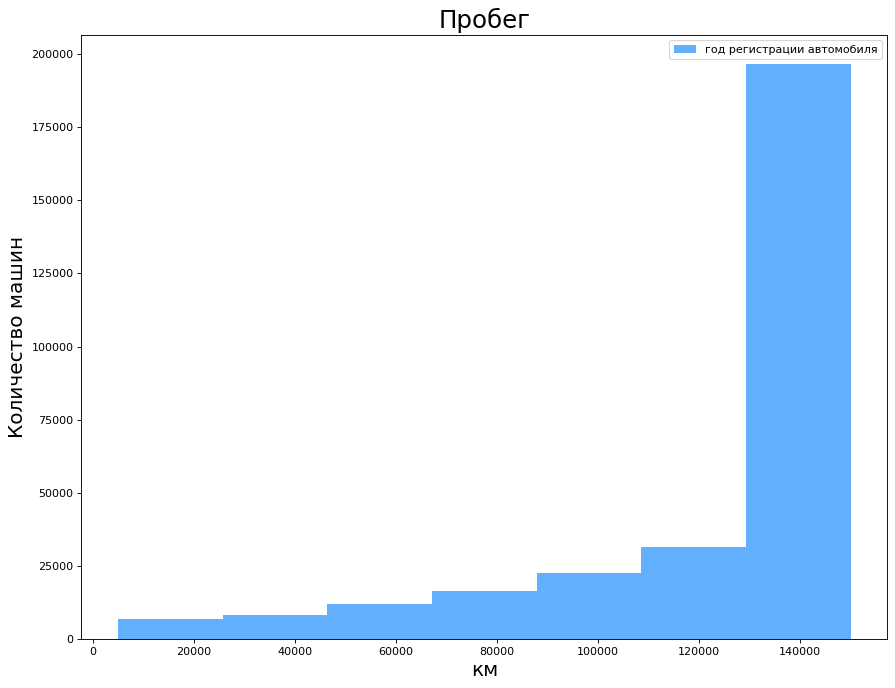

In [59]:
plt.figure(figsize=(13,10), dpi= 80)
sns.distplot(data['kilometer'], color="dodgerblue",label="год регистрации автомобиля", bins=7, 
             hist_kws={'alpha':.7}, kde=False)
plt.title('Пробег', fontsize=22)
plt.xlabel('км', fontsize=18)
plt.ylabel('Количество машин', fontsize=18)
plt.legend()
plt.show()

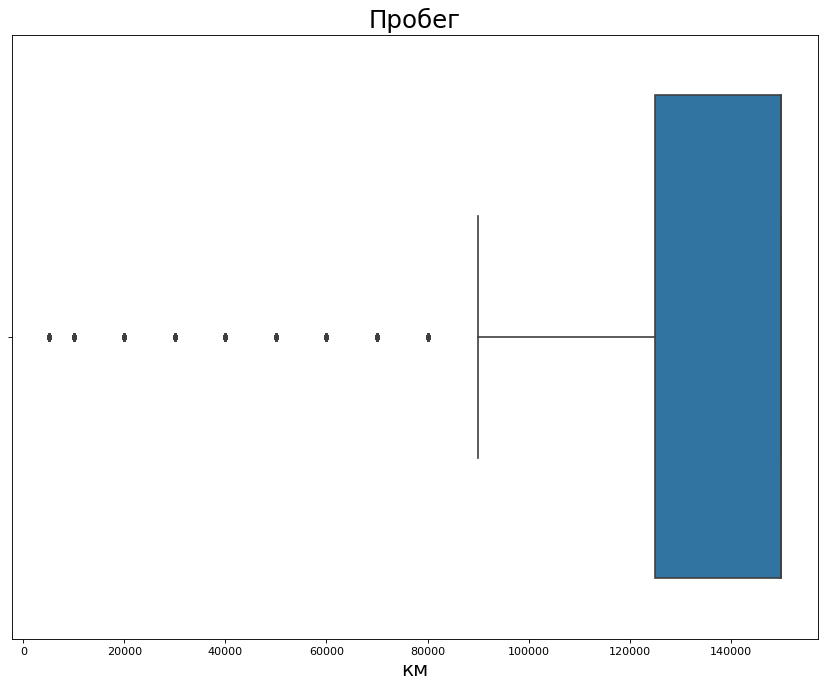

In [60]:
plt.figure(figsize=(13,10), dpi= 80)
sns.boxplot(data['kilometer'])
plt.title('Пробег', fontsize=22)
plt.xlabel('км', fontsize=18)
plt.show()

### `price`

In [61]:
data['price'].value_counts()

0        5900
500      4325
1500     4289
1200     3619
2500     3580
         ... 
15911       1
6434        1
6039        1
3988        1
8188        1
Name: price, Length: 3556, dtype: int64

Существуют позиции где цена равно 0. С этими данными мы ничего сделать не можем, так что придется их удалить

In [62]:
data = data.query('price > 0')

In [63]:
data['price'].describe()

count    288029.000000
mean       4869.738703
std        4612.568184
min           1.000000
25%        1350.000000
50%        3200.000000
75%        6999.000000
max       20000.000000
Name: price, dtype: float64

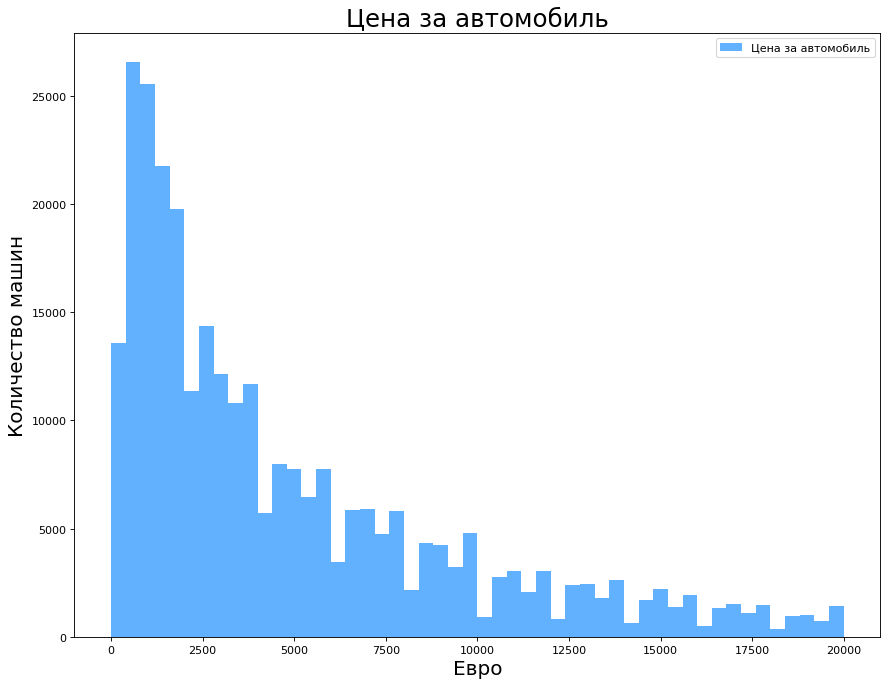

In [64]:
plt.figure(figsize=(13,10), dpi= 80)
sns.distplot(data['price'], color="dodgerblue",label="Цена за автомобиль", bins=50, 
             hist_kws={'alpha':.7}, kde=False)
plt.title('Цена за автомобиль', fontsize=22)
plt.xlabel('Евро', fontsize=18)
plt.ylabel('Количество машин', fontsize=18)
plt.legend()
plt.show()

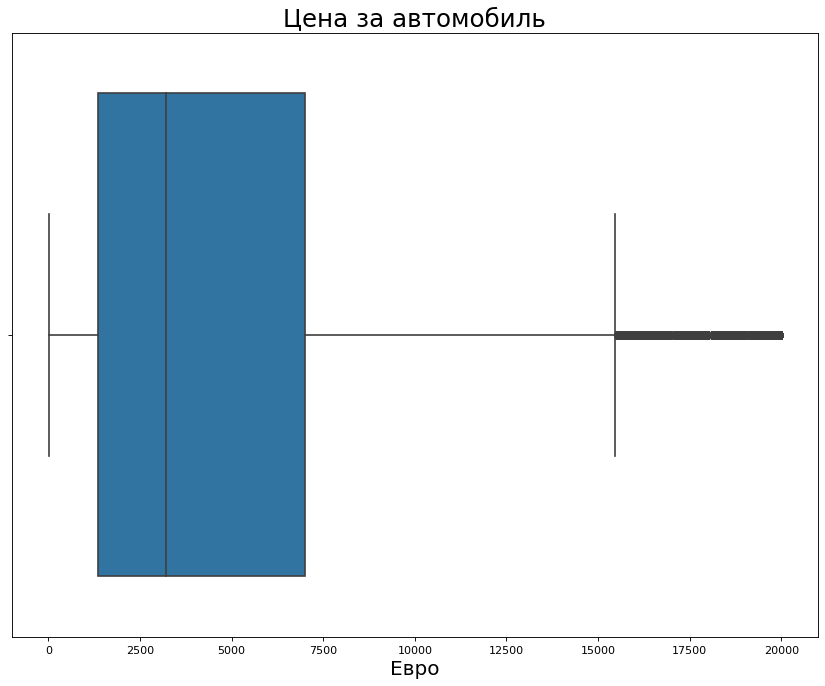

In [65]:
plt.figure(figsize=(13,10), dpi= 80)
sns.boxplot(data['price'])
plt.title('Цена за автомобиль', fontsize=22)
plt.xlabel('Евро', fontsize=18)
plt.show()

Не будем удалять выбросы более 15.000 евро, так как это не единичные случаи и максимальная цена в 20.000 евро достаточно не высокая

### Проверка на дубликаты

In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288029 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              288029 non-null  int64 
 1   vehicle_type       288029 non-null  object
 2   registration_year  288029 non-null  int64 
 3   gearbox            288029 non-null  object
 4   power              288029 non-null  int64 
 5   model              288029 non-null  object
 6   kilometer          288029 non-null  int64 
 7   fuel_type          288029 non-null  object
 8   brand              288029 non-null  object
 9   not_repaired       288029 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.2+ MB


In [67]:
data.duplicated().sum()

45757

In [68]:
data = data.drop_duplicates()

In [69]:
data.duplicated().sum()

0

In [70]:
data.shape

(242272, 10)

**Вывод**

На данном этапе были изучены и обработанны предаставленные данные.
- Выведены аномалии и пропущенные значения.
- Удаленны столбцы, которые не нужны для дальнейшего построения моделей.
- Исправленны некорректные данные.
- Подробно изучены количественные переменные в данных и удалены выбросы.
- Удаленно достаточно много данных для достижения максимально точных метрик в дальнейшем обучении моделей.

## Обучение моделей

Создадим таблицу, в которую в последующем будем загружать наши данные с разных моделей обучения. А также напишем функцию для упрощения ввода данных в эту таблицу

In [71]:
metrics_results = pd.DataFrame(columns=['RMSE_train','Learn_time_train', 'Predict_time_train'])

In [72]:
metrics_results

,RMSE_train,Learn_time_train,Predict_time_train


In [73]:
def metrics(model_name, RMSE_train, Learn_time_train, Predict_time_train):
    metrics_results.loc[model_name,'RMSE_train'] = RMSE_train
    metrics_results.loc[model_name,'Learn_time_train'] = Learn_time_train
    metrics_results.loc[model_name,'Predict_time_train'] = Predict_time_train

    return metrics_results

Подготовим наши данные и используем два метода кодирования:
- Прямое кодирование;
- Порядковое кодирование.

In [74]:
data_copy = data.copy()

# OHE кодирование
data_ohe = pd.get_dummies(data_copy)

# порядковое кодирование
encoder = OrdinalEncoder()
data_ordinal = data_copy
columns=['vehicle_type','model','fuel_type','brand','gearbox','not_repaired']
data_encoder = pd.DataFrame(encoder.fit_transform(data_copy[columns]),
                            columns=data_copy[columns].columns,
                           index=data_copy[columns].index)
for column in columns:
    data_ordinal[column] = data_encoder[column]

In [75]:
data_ohe.head()

,price,registration_year,power,kilometer,vehicle_type_bus,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_no,not_repaired_yes
1,18300,2011,190,125000,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163,125000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75,150000,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
4,3600,2008,69,90000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
5,650,1995,102,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [76]:
data_ordinal.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
1,18300,2.0,2011,1.0,190,166.0,125000,5.0,1.0,1.0
2,9800,6.0,2004,0.0,163,117.0,125000,5.0,14.0,0.0
3,1500,5.0,2001,1.0,75,116.0,150000,5.0,38.0,0.0
4,3600,5.0,2008,1.0,69,101.0,90000,5.0,31.0,0.0
5,650,4.0,1995,1.0,102,11.0,150000,5.0,2.0,1.0


Разделим наши данные на выборки, а также проведен масштабирование для прямого кодирования

In [77]:
# разделение на выборке при OHE кодироваоние
features_ohe = data_ohe.drop(['price'], axis=1)
target_ohe = data_ohe['price']

features_ohe_train, features_ohe_test, target_ohe_train, target_ohe_test = train_test_split(features_ohe,
                                                                                            target_ohe, test_size=0.25, random_state=12345)


# разделение на выборки при Порядковом кодирование
features_ordinal = data_ordinal.drop(['price'], axis=1)
target_ordinal = data_ordinal['price']

features_ordinal_train, features_ordinal_test, target_ordinal_train, target_ordinal_test = train_test_split(features_ordinal,
                                                                                            target_ordinal, test_size=0.25, random_state=12345)

In [78]:
features_ordinal_train.shape

(181704, 9)

### Линейная регрессия

In [79]:
model_LR = LinearRegression()
cv_model_LR = (cross_val_score(model_LR,
                               features_ohe_train,
                               target_ohe_train, 
                               cv=5, 
                               scoring='neg_mean_squared_error').mean() * -1) ** 0.5

print("Метрика RMSE Линейной регресии с использованием Прямого кодирования:", cv_model_LR)

Метрика RMSE Линейной регресии с использованием Прямого кодирования: 2520.2325572021205


In [80]:
start_time = time.time()
model_LR.fit(features_ohe_train, target_ohe_train)
time_learn_lr= round(time.time() - start_time,2)

In [81]:
start_time = time.time()
prediction_lr =  model_LR.predict(features_ohe_train)
time_predict_lr= round(time.time() - start_time,2)

In [82]:
metrics('LinearRegression', cv_model_LR, time_learn_lr, time_predict_lr)

,RMSE_train,Learn_time_train,Predict_time_train
LinearRegression,2520.232557,21.21,0.59


### Дерево решений

In [83]:
parametrs_dr = {'max_depth': range(2, 30)}
model_dr = DecisionTreeRegressor(random_state=12345)

grid_dr = GridSearchCV(model_dr,
                      parametrs_dr,
                      cv=5,
                      scoring='neg_mean_squared_error')
grid_dr.fit(features_ordinal_train, target_ordinal_train)
RMSE_dr_train = (-grid_dr.best_score_) ** 0.5
print('Показатель RMSE:', RMSE_dr_train, 'при глубине:', grid_dr.best_params_)

Показатель RMSE: 1901.970243845917 при глубине: {'max_depth': 13}


In [84]:
start_time = time.time()
grid_dr.best_estimator_.fit(features_ordinal_train, target_ordinal_train)
time_learn_dr= round(time.time() - start_time,2)

In [85]:
start_time = time.time()
prediction_dr=grid_dr.best_estimator_.predict(features_ordinal_train)
time_predict_dr= round(time.time() - start_time,2)

In [86]:
metrics('DecisionTreeRegressor', RMSE_dr_train, time_learn_dr, time_predict_dr)

,RMSE_train,Learn_time_train,Predict_time_train
LinearRegression,2520.232557,21.21,0.59
DecisionTreeRegressor,1901.970244,0.42,0.03


### Случайный лес

In [87]:
parametrs_rf = {'n_estimators': range(0, 40, 5)}
model_rf = RandomForestRegressor(random_state=12345)

grid_rf = GridSearchCV(model_rf,
                      parametrs_rf,
                      cv=5,
                      scoring='neg_mean_squared_error')
grid_rf.fit(features_ordinal_train, target_ordinal_train)
RMSE_rf_train = (-grid_rf.best_score_) ** 0.5
print('Показатель RMSE:', RMSE_rf_train, 'при количестве деревьев:', grid_rf.best_params_)

Показатель RMSE: 1694.3115611214923 при количестве деревьев: {'n_estimators': 35}


In [88]:
start_time = time.time()
grid_rf.best_estimator_.fit(features_ordinal_train, target_ordinal_train)
time_learn_rf= round(time.time() - start_time,2)

In [89]:
start_time = time.time()
prediction_rf=grid_rf.best_estimator_.predict(features_ordinal_train)
time_prediction_rf= round(time.time() - start_time,2)

In [91]:
metrics('RandomForestRegressor', RMSE_rf_train, time_learn_rf, time_prediction_rf)

,RMSE_train,Learn_time_train,Predict_time_train
LinearRegression,2520.232557,21.21,0.59
DecisionTreeRegressor,1901.970244,0.42,0.03
RandomForestRegressor,1694.311561,14.59,2.78


### Light Gradient Boosted Machine (LightGBM)

In [115]:
parametrs_lgbm = {'max_depth': [5,10],
                  "n_estimators": range (5, 15, 5),
                 'learning_rate': [0.1,0.4]}

model_lgbm = LGBMRegressor(random_state=12345)

grid_lgbm = GridSearchCV(model_lgbm,
                      parametrs_lgbm,
                      cv=5,
                      scoring='neg_mean_squared_error')
grid_lgbm.fit(features_ordinal_train, target_ordinal_train)
RMSE_lgbm_train = (-grid_lgbm.best_score_) ** 0.5
print('Показатель RMSE:', RMSE_lgbm_train, 'при параметрах:', grid_lgbm.best_params_)

Показатель RMSE: 1846.2548374288567 при параметрах: {'learning_rate': 0.4, 'max_depth': 10, 'n_estimators': 10}


In [116]:
start_time = time.time()
grid_lgbm.best_estimator_.fit(features_ordinal_train, target_ordinal_train)
time_learn_lgbm= round(time.time() - start_time,2)

In [117]:
start_time = time.time()
prediction_lgbm=grid_lgbm.best_estimator_.predict(features_ordinal_train)
time_prediction_lgbm= round(time.time() - start_time,2)

In [118]:
metrics('LGBMRegressor', RMSE_lgbm_train, time_learn_lgbm, time_prediction_lgbm)

,RMSE_train,Learn_time_train,Predict_time_train
LinearRegression,2520.232557,21.21,0.59
DecisionTreeRegressor,1901.970244,0.42,0.03
RandomForestRegressor,1694.311561,14.59,2.78
LGBMRegressor,1846.254837,20.21,0.2


### CatBoost Regressor

In [119]:
parametrs_cb = [{'learning_rate':[0.1, 0.5, 0.8],
                'verbose' : [250],
                'n_estimators' : [40, 80]}]

model_cb = CatBoostRegressor(random_state=12345)

grid_cb = GridSearchCV(model_cb,
                      parametrs_cb,
                      cv=5,
                      scoring='neg_mean_squared_error')
grid_cb.fit(features_ordinal_train, target_ordinal_train)
RMSE_cb_train = (-grid_cb.best_score_) ** 0.5
print('Показатель RMSE:', RMSE_cb_train, 'при параметрах:', grid_cb.best_params_)

0:	learn: 4371.7371133	total: 96.5ms	remaining: 3.76s
39:	learn: 1977.9691019	total: 1.01s	remaining: 0us
0:	learn: 4377.1406960	total: 19.9ms	remaining: 775ms
39:	learn: 1992.5658711	total: 873ms	remaining: 0us
0:	learn: 4376.7432126	total: 20.7ms	remaining: 806ms
39:	learn: 1994.5062317	total: 865ms	remaining: 0us
0:	learn: 4370.6451926	total: 21.2ms	remaining: 826ms
39:	learn: 1984.4775941	total: 853ms	remaining: 0us
0:	learn: 4367.3126538	total: 21.3ms	remaining: 830ms
39:	learn: 1972.6044782	total: 825ms	remaining: 0us
0:	learn: 4371.7371133	total: 19.9ms	remaining: 1.57s
79:	learn: 1838.9414784	total: 1.59s	remaining: 0us
0:	learn: 4377.1406960	total: 22ms	remaining: 1.74s
79:	learn: 1846.2929389	total: 1.63s	remaining: 0us
0:	learn: 4376.7432126	total: 18.5ms	remaining: 1.46s
79:	learn: 1839.6844562	total: 1.67s	remaining: 0us
0:	learn: 4370.6451926	total: 20.4ms	remaining: 1.61s
79:	learn: 1836.0275302	total: 1.69s	remaining: 0us
0:	learn: 4367.3126538	total: 21.5ms	remaining: 

In [120]:
start_time = time.time()
grid_cb.best_estimator_.fit(features_ordinal_train, target_ordinal_train)
time_learn_cb= round(time.time() - start_time,2)

0:	learn: 2757.4015349	total: 30.7ms	remaining: 2.42s
79:	learn: 1626.2482111	total: 2.17s	remaining: 0us


In [121]:
start_time = time.time()
prediction_cb=grid_cb.best_estimator_.predict(features_ordinal_train)
time_prediction_cb= round(time.time() - start_time,2)

In [122]:
metrics('CatBoostRegressor', RMSE_cb_train, time_learn_cb, time_prediction_cb)

,RMSE_train,Learn_time_train,Predict_time_train
LinearRegression,2520.232557,21.21,0.59
DecisionTreeRegressor,1901.970244,0.42,0.03
RandomForestRegressor,1694.311561,14.59,2.78
LGBMRegressor,1846.254837,20.21,0.2
CatBoostRegressor,1688.273284,2.9,0.04


Были построенны 5 моделей машинного обучения. Изучены метрики RMSE и время на предсказание моделей и сведены в общую таблицу

## Анализ моделей

Посмотрим на все полученные данные

In [123]:
metrics_results['Model'] = metrics_results.index

In [124]:
metrics_results

,RMSE_train,Learn_time_train,Predict_time_train,Model
LinearRegression,2520.232557,21.21,0.59,LinearRegression
DecisionTreeRegressor,1901.970244,0.42,0.03,DecisionTreeRegressor
RandomForestRegressor,1694.311561,14.59,2.78,RandomForestRegressor
LGBMRegressor,1846.254837,20.21,0.2,LGBMRegressor
CatBoostRegressor,1688.273284,2.9,0.04,CatBoostRegressor


Можем увидеть, что на обучающей выборке лучший результат показал CatBoostRegressor. Совсем немного уступает RandomForestRegressor, но дольше происходит обучение. По времени лидирует DecisionTreeRegressor, но уступает по качестве метрики RMSE

Так как заказчик не сообщил, какой из параметров в приоритете, то будем тестировать модель с наилучшим показателем метрики RMSE а именно CatBoostRegressor на тестовой выборке с наилучшими гиперпараметрами

In [129]:
start_time = time.time()
prediction_cb_test = grid_cb.best_estimator_.predict(features_ordinal_test)
time_prediction_cb_test= round(time.time() - start_time,2)
RMSE_cb_test = mean_squared_error(target_ordinal_test, prediction_cb_test) ** 0.5
print('Показатель RMSE:', round(RMSE_cb_test,4), 'Время предсказания:', time_prediction_cb_test)

Показатель RMSE: 1688.3637 Время предсказания: 0.01


## Вывод

В ходе работы было выполнено:
- Предобработка данных:
    - Выведены аномалии и пропущенные значения.;
    - Исправленны некорректные данные;
    - Подробно изучены количественные переменные в данных и удалены выбросы.
- Обучение моделей:
    - Построены 5 моделей машинного улучшения для выявления самого подходящего метода.

По итогам построения моделей выявлена лучшая модель на тестовой выборке: CatBoostRegressor (Показатель метрики RMSE = 1688.36, время предсказания: 0.01 с.
